In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import sys
#Insert your path to the locally installed geoopt
sys.path.append('../../geoopt')
import geoopt
import torch
import itertools
import torch.nn as nn
import torch.nn.init as init

import math
import numpy as np
import tqdm
%matplotlib inline
# import importlib
# importlib.reload(geoopt)

In [99]:
ball = geoopt.PoincareBall(c=0.8)
torch.manual_seed(42)


## Visualizing the data

In [3]:
#@title long util funtion to plot geodesic grid
def add_geodesic_grid(ax: plt.Axes, manifold: geoopt.Stereographic, line_width=0.1):

    # define geodesic grid parameters
    N_EVALS_PER_GEODESIC = 10000
    STYLE = "--"
    COLOR = "gray"
    LINE_WIDTH = line_width

    # get manifold properties
    K = manifold.k.item()
    R = manifold.radius.item()

    # get maximal numerical distance to origin on manifold
    if K < 0:
        # create point on R
        r = torch.tensor((R, 0.0), dtype=manifold.dtype)
        # project point on R into valid range (epsilon border)
        r = manifold.projx(r)
        # determine distance from origin
        max_dist_0 = manifold.dist0(r).item()
    else:
        max_dist_0 = np.pi * R
    # adjust line interval for spherical geometry
    circumference = 2*np.pi*R

    # determine reasonable number of geodesics
    # choose the grid interval size always as if we'd be in spherical
    # geometry, such that the grid interpolates smoothly and evenly
    # divides the sphere circumference
    n_geodesics_per_circumference = 4 * 6  # multiple of 4!
    n_geodesics_per_quadrant = n_geodesics_per_circumference // 2
    grid_interval_size = circumference / n_geodesics_per_circumference
    if K < 0:
        n_geodesics_per_quadrant = int(max_dist_0 / grid_interval_size)

    # create time evaluation array for geodesics
    if K < 0:
        min_t = -1.2*max_dist_0
    else:
        min_t = -circumference/2.0
    t = torch.linspace(min_t, -min_t, N_EVALS_PER_GEODESIC)[:, None]

    # define a function to plot the geodesics
    def plot_geodesic(gv):
        ax.plot(*gv.t().numpy(), STYLE, color=COLOR, linewidth=LINE_WIDTH)

    # define geodesic directions
    u_x = torch.tensor((0.0, 1.0))
    u_y = torch.tensor((1.0, 0.0))

    # add origin x/y-crosshair
    o = torch.tensor((0.0, 0.0))
    if K < 0:
        x_geodesic = manifold.geodesic_unit(t, o, u_x)
        y_geodesic = manifold.geodesic_unit(t, o, u_y)
        plot_geodesic(x_geodesic)
        plot_geodesic(y_geodesic)
    else:
        # add the crosshair manually for the sproj of sphere
        # because the lines tend to get thicker if plotted
        # as done for K<0
        ax.axvline(0, linestyle=STYLE, color=COLOR, linewidth=LINE_WIDTH)
        ax.axhline(0, linestyle=STYLE, color=COLOR, linewidth=LINE_WIDTH)

    # add geodesics per quadrant
    for i in range(1, n_geodesics_per_quadrant):
        i = torch.as_tensor(float(i))
        # determine start of geodesic on x/y-crosshair
        x = manifold.geodesic_unit(i*grid_interval_size, o, u_y)
        y = manifold.geodesic_unit(i*grid_interval_size, o, u_x)

        # compute point on geodesics
        x_geodesic = manifold.geodesic_unit(t, x, u_x)
        y_geodesic = manifold.geodesic_unit(t, y, u_y)

        # plot geodesics
        plot_geodesic(x_geodesic)
        plot_geodesic(y_geodesic)
        if K < 0:
            plot_geodesic(-x_geodesic)
            plot_geodesic(-y_geodesic)

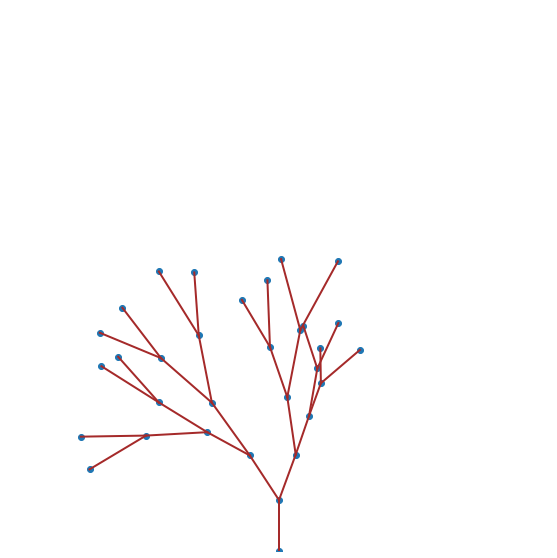

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use("CMS")

# Define a function to draw a tree branch and collect nodes
def draw_branch(x, y, length, angle, depth, nodes):
    if depth == 0:
        return
    x_end = x + length * 0.7 * angle[0]
    y_end = y + length * 0.7 * angle[1]
    
    # Collect the coordinates of the split (node)
    nodes.append((x_end, y_end))
    
    plt.plot([x, x_end], [y, y_end], color='brown', lw=2,linestyle= '-')
    
    new_length = length * 0.8
    draw_branch(x_end, y_end, new_length + np.random.uniform(0, 0.2), rotate(angle, 15 + np.random.uniform(-20, 20)), depth - 1, nodes)
    draw_branch(x_end, y_end, new_length + np.random.uniform(0, 0.2), rotate(angle, -15+ np.random.uniform(-20, 20)), depth - 1, nodes)

# Define a function to rotate a vector by an angle
def rotate(vector, angle):
    x, y = vector
    angle_rad = angle * (np.pi / 180)  # Convert to radians
    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return x_new, y_new

# Create a figure and axis
fig, ax = plt.subplots()

# Set the aspect ratio to make sure the tree looks proportional
ax.set_aspect('equal', adjustable='box')

# Starting point and angle
x_start, y_start = 0, 0
initial_angle = (0, 1)  # Straight up

# Initialize an empty list to collect nodes
nodes = [(x_start, y_start)]

# Call the function to draw the tree and collect nodes
draw_branch(x_start, y_start, 0.4, initial_angle, 5, nodes)
nodes = np.array(nodes)
# Set axis limits and labels
ax.set_xlim(-1.5, 1.5)
plt.scatter(nodes[:,0],nodes[:,1])
ax.set_ylim(0, 3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('off')


# Show the plot
plt.show()




In [83]:
np.linalg.norm(nodes[9]-nodes[10])

0.8321286941728128

In [92]:
ball.geodesic(torch.tensor(0),embedded[3],embedded[30])

tensor([-0.3723,  0.6481], dtype=torch.float64)

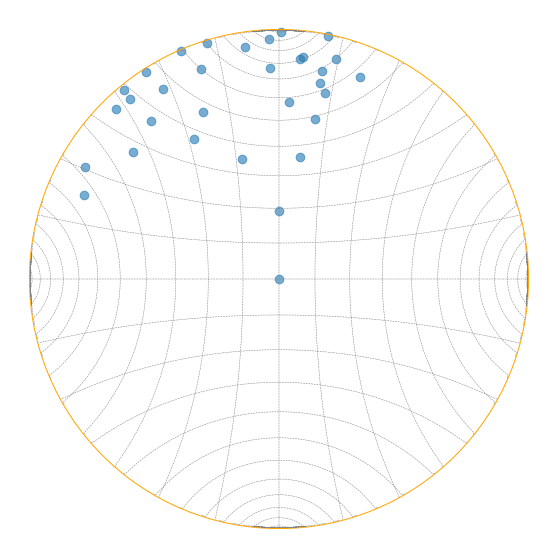

In [116]:
embedded = ball.expmap0(torch.tensor(nodes)).squeeze()
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1.01, fill=False, color="orange")
add_geodesic_grid(plt.gca(), ball, 0.5)
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
plt.gca().axis('off')
# plt.title('Poincare Ball $\mathbb{B}$')
plt.scatter(*embedded.data.T,alpha=.6,s = 75 )
# plt.scatter(*dataset.data.T, 
#             c=dataset.labels.max(-1).values.float() / num_classes, 
#             alpha=.3, cmap="rainbow");
plt.show()

Probably the most interesting (engeneering) part of the notebook. Here I create a pytorch layer that works on manifold and has manifold parameters. Essentially? I've copied this code from `geoopt-layers` library which is not yet published (but will be soon).  